# Обработка лабы 5.5

In [1]:
# Импротируем необходимые функции
import numpy as np # работа с массивами и линейной алгеброй
import matplotlib.pyplot as plt # для отрисовки графиков
import pandas as pd # для чтения и работы с данными
from scipy.optimize import curve_fit # фитирующая процедура

In [2]:
# Функция, которая приводит данные к нужному виду
def read_file(path):
    df = pd.read_excel(path)
    df = df.drop(df.index[[0,1,2,3,4]])
    df.columns = ['Channel', 'Counts']
    df.index = np.arange(0, len(df))
    df['Counts'] = df['Counts'].apply(np.float64)
    df['Channel'] = df['Channel'].apply(np.float64)
    df['Error'] = df['Counts']
    df['Error'] = df['Error'].apply(np.sqrt)
    return df

In [3]:
# Функция, которая рисует датасет
def draw(df, title, err = False):
    x = df["Channel"]
    y = df["Counts"]
    plt.figure(figsize=(15,7))
    if(err):
        plt.errorbar(x, y, yerr=df['Error'], color = "green")
        plt.scatter(x, y, label='Данные'.decode('utf-8'))
    else:
        plt.plot(x, y, label='Данные'.decode('utf-8'))
    plt.title(title)
    plt.legend()
    plt.grid() # Активирует сетку

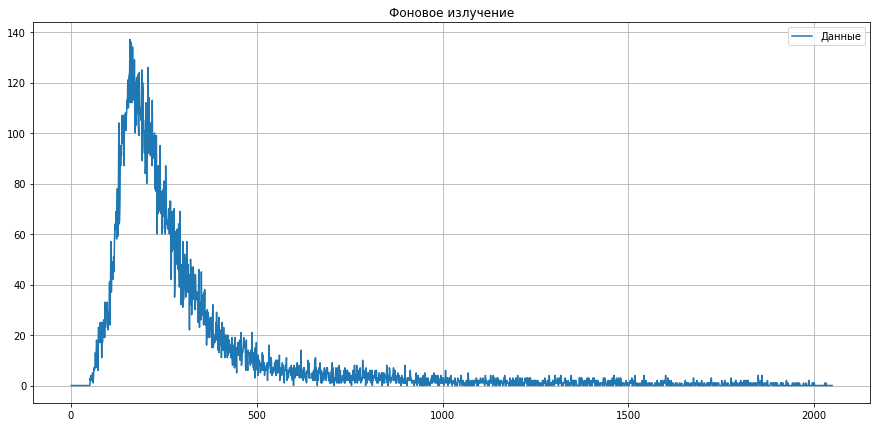

In [4]:
# Импорт данных (поработаем пока с фоном)
data_b = read_file('data/excel/background.xlsx')
draw(data_b, 'Фоновое излучение'.decode('utf-8'))
plt.show()

Будем фитировать фоновое излучение экспонентой вида
$a\cdot e^{-b(x-x_0)}$, начиная с того момента, как фон падает.

In [5]:
# Функция экспоненты (делим x на тысячу, чтобы фитирование не баговало)
def exp(x, a, b, x0):
    return a*np.exp(-b*(x/1000.0-x0))

In [6]:
delta_1 = 160
delta_2 = len(data_b)
data_b_exp = data_b.iloc[delta_1:delta_2]

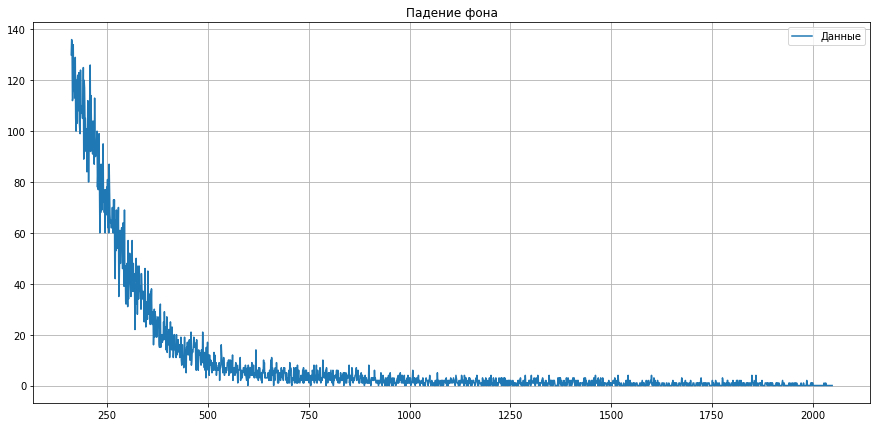

In [7]:
draw(data_b_exp, 'Падение фона'.decode('utf-8'))
plt.show()

In [8]:
popt_b, pcov_b = curve_fit(f = exp, xdata= data_b_exp['Channel'], ydata=data_b_exp['Counts'], maxfev=10000)
popt_b

array([ 0.16612494,  7.55330569,  1.04704429])

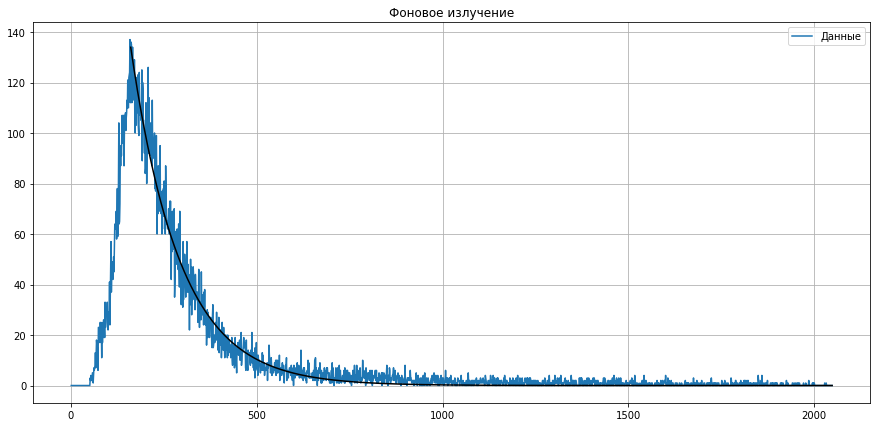

In [9]:
draw(data_b, 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_b_exp['Channel'], exp(data_b_exp['Channel'], *popt_b), color = 'black')
plt.show()

Таким образом искомая функция, фитирующая фон есть
$$
y = 0.166\cdot e^{-7.553\cdot 10^{-3}(x-1047)}.
$$

Теперь посмотрим на спектр $Co_{60}$.

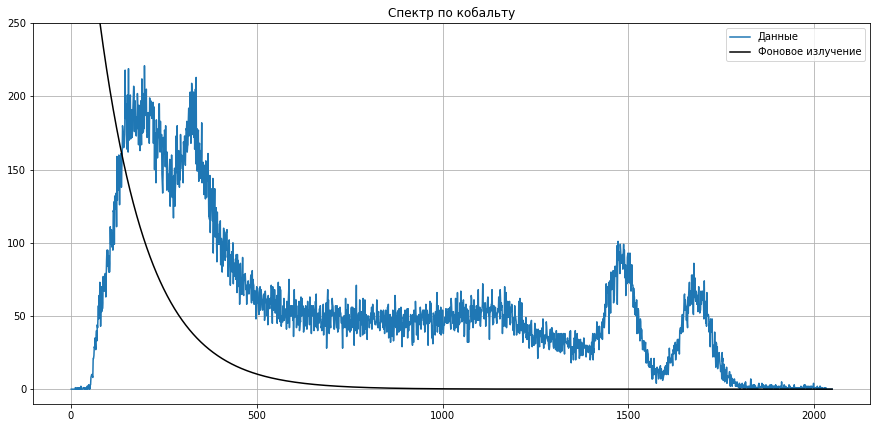

In [10]:
data_co = read_file('data/excel/Co60.xlsx')
draw(data_co, 'Спектр по кобальту'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,250)
plt.show()

Отчетливо видны два фотопика, пик обратного рассеивания и пик характеристического излучения.

Для начала найдем значения каналов для фотопиков. Для этого фитируем их под функцию нормального распределения.

In [105]:
# Функция нормального распределения
def gauss_function_c(x, a, x0, s, c):
    return a*np.exp(-(x/1000.0-x0)**2/(2*s**2)) + c

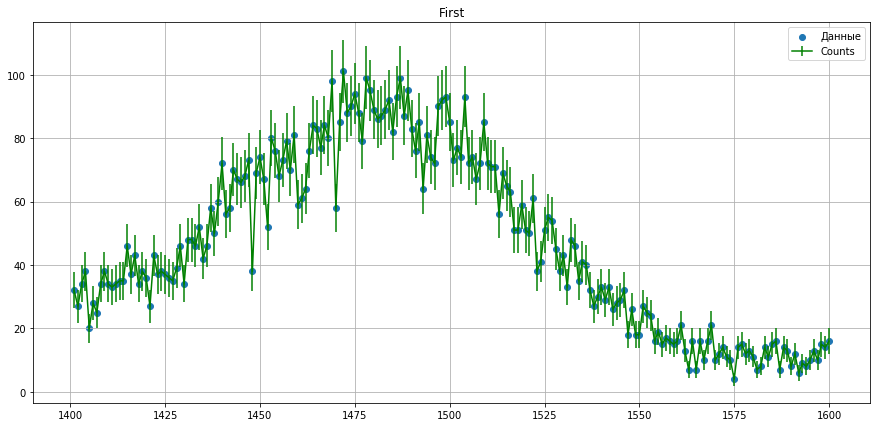

In [12]:
# Выделим первый пик
delta_1 = 1400
delta_2 = 1600

data_co_f = data_co.iloc[delta_1:delta_2]
draw(data_co_f, 'First', True)
plt.show()

In [13]:
popt_co_f, pcov_co_f = curve_fit(f = gauss_function_c, 
                                 xdata= data_co_f['Channel'], 
                                 ydata=data_co_f['Counts'], maxfev=10000, sigma = data_co_f['Error'])
popt_co_f

array([  7.85234886e+01,   1.47789389e+00,  -3.97644235e-02,
         7.71111590e+00])

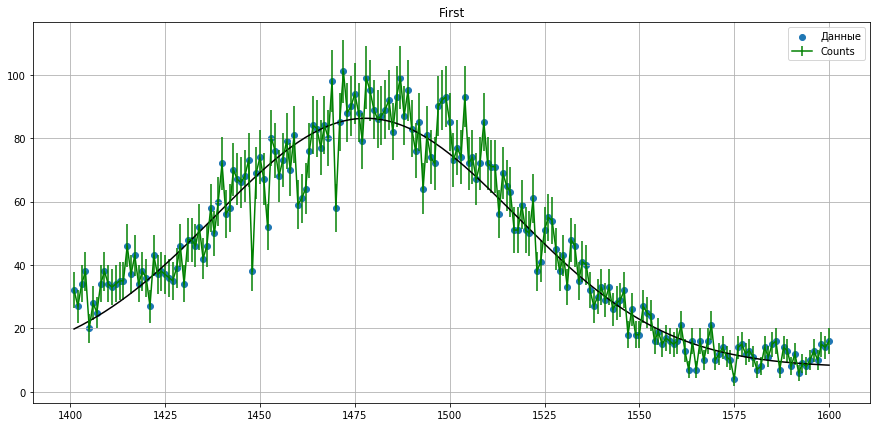

In [14]:
draw(data_co_f, 'First', True)
plt.plot(data_co_f['Channel'], gauss_function_c(data_co_f['Channel'], *popt_co_f), color = 'black')
plt.show()

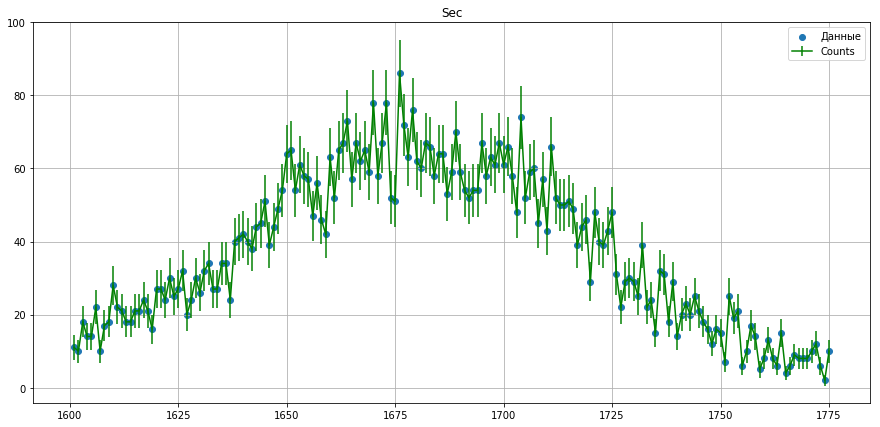

In [15]:
# Выделим второй пик
delta_1 = 1600
delta_2 = 1775

data_co_sec = data_co.iloc[delta_1:delta_2]
draw(data_co_sec, 'Sec', True)
plt.show()

In [16]:
popt_co_sec, pcov_co_sec = curve_fit(f = gauss_function_c, 
                                 xdata= data_co_sec['Channel'], 
                                 ydata=data_co_sec['Counts'], maxfev=10000, sigma = data_co_sec['Error'])
popt_co_sec

array([  6.34947291e+01,   1.67920941e+00,  -3.95536755e-02,
         1.58252518e+00])

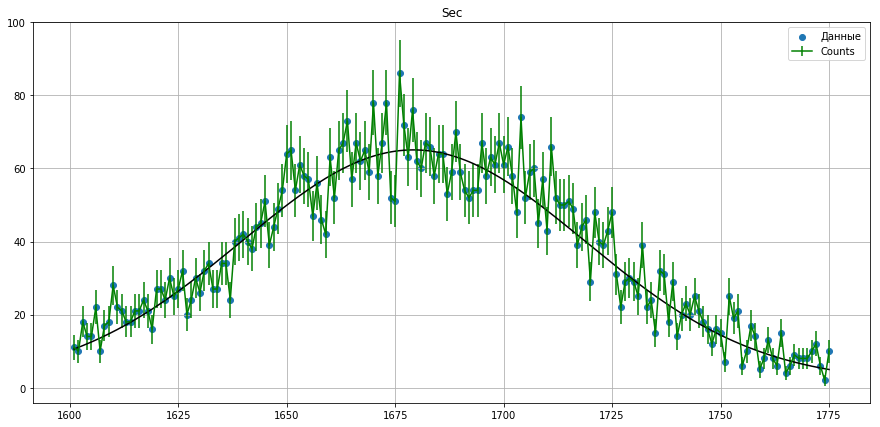

In [17]:
draw(data_co_sec, 'Sec', True)
plt.plot(data_co_sec['Channel'], gauss_function_c(data_co_sec['Channel'], *popt_co_sec), color = 'black')
plt.show()

Что же получилось в итоге?

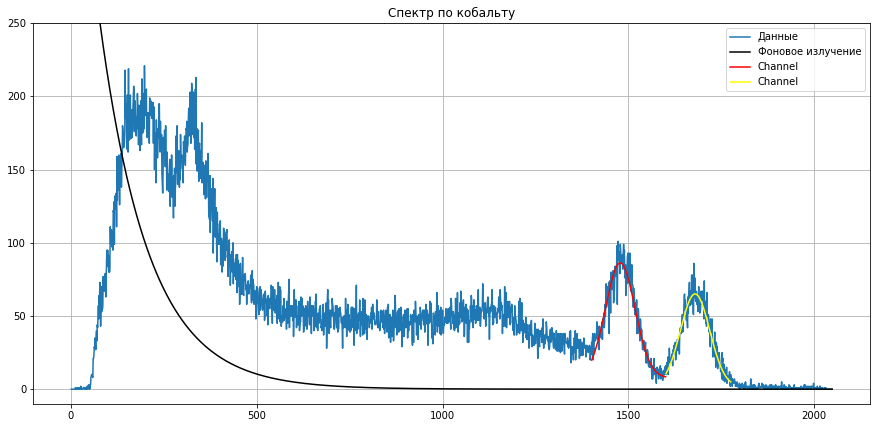

In [18]:
data_co = read_file('data/excel/Co60.xlsx')
draw(data_co, 'Спектр по кобальту'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_co_f['Channel'], gauss_function_c(data_co_f['Channel'], *popt_co_f), color = 'red')
plt.plot(data_co_sec['Channel'], gauss_function_c(data_co_sec['Channel'], *popt_co_sec), color = 'yellow')
plt.legend()
plt.ylim(-10,250)
plt.show()

Таким образом, получаем
$$
E_{1478\pm4} = 1.173 \text{ МэВ}\\
E_{1679\pm4} = 1.332 \text{ МэВ}
$$

### Пики полного полгощения Na и Cs
#### Пик Na

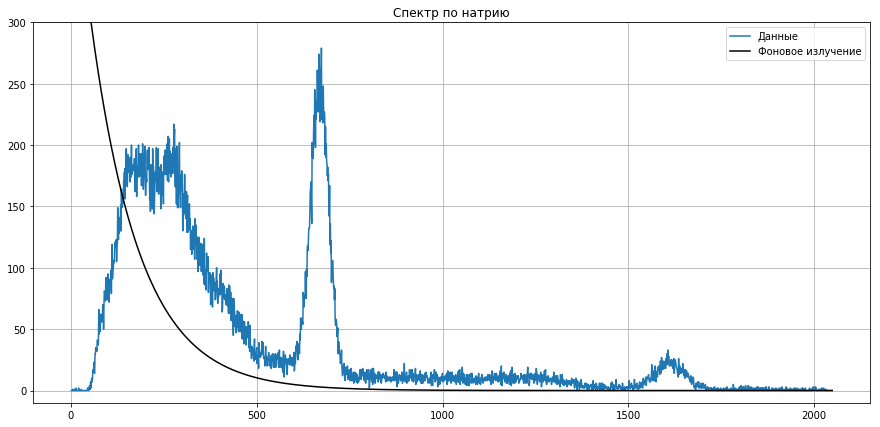

In [106]:
data_na = read_file('data/excel/Na22.xlsx')
draw(data_na, 'Спектр по натрию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,300)
plt.show()

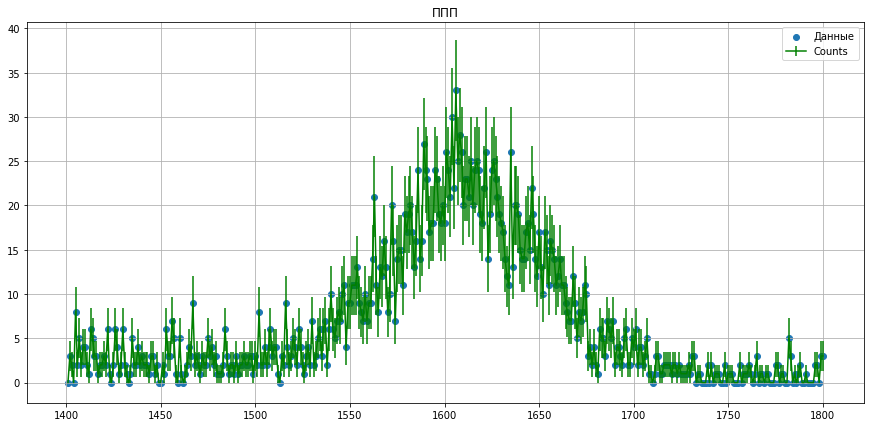

In [107]:
delta_1 = 1400
delta_2 = 1800

data_na_pp = data_na.iloc[delta_1:delta_2]
draw(data_na_pp, 'ППП'.decode('utf-8'), True)
plt.show()

In [108]:
popt_na_pp, pcov_na_pp = curve_fit(f = gauss_function_c, 
                                 xdata= data_na_pp['Channel'], 
                                 ydata=data_na_pp['Counts'], maxfev=10000)
popt_na_pp

array([ 20.86331376,   1.61016447,   0.03836755,   1.8637734 ])

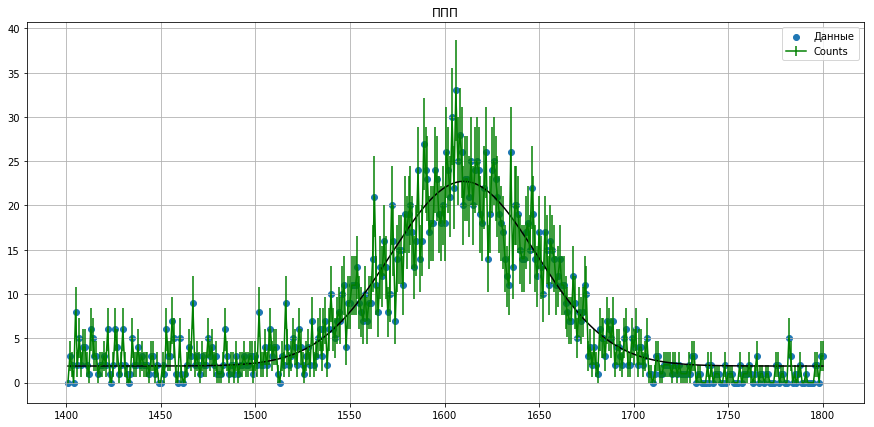

In [109]:
draw(data_na_pp, 'ППП'.decode('utf-8'), True)
plt.plot(data_na_pp['Channel'], gauss_function_c(data_na_pp['Channel'], *popt_na_pp), color = 'black')
plt.show()

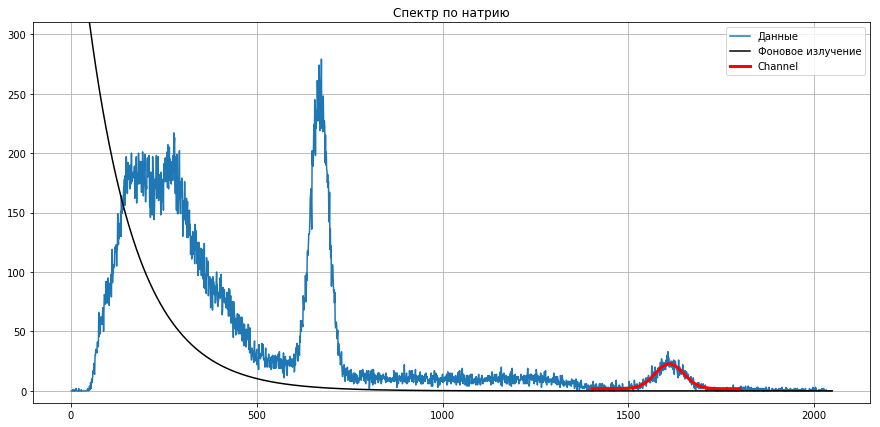

In [110]:
draw(data_na, 'Спектр по натрию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_na_pp['Channel'], gauss_function_c(data_na_pp['Channel'], *popt_na_pp), color = 'red', linewidth = 3)
plt.legend()
plt.ylim(-10,310)
plt.show()

Каналу ППП натрия $(160\pm4)\cdot 10$ соответсвтует энергия $E_{\text{ППП}} = 1.275 \text{ МэВ}$.

#### Пик Cs

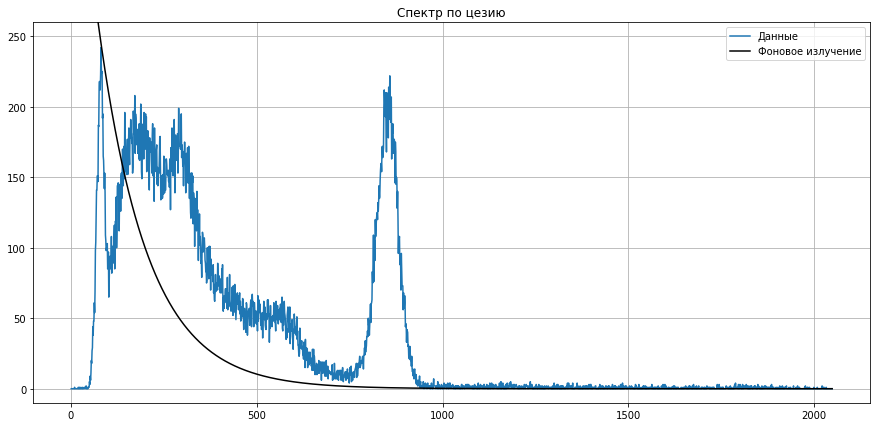

In [111]:
data_cs = read_file('data/excel/Cs137.xlsx')
draw(data_cs, 'Спектр по цезию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.legend()
plt.ylim(-10,260)
plt.show()

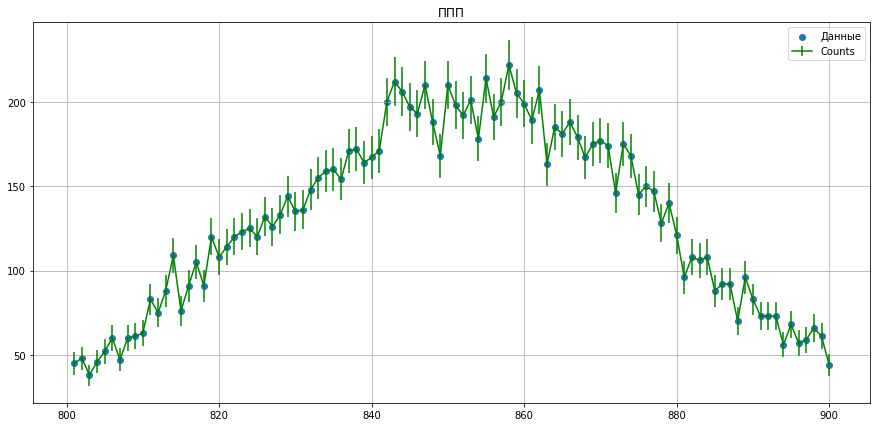

In [116]:
delta_1 = 800
delta_2 = 900

data_cs_pp = data_cs.iloc[delta_1:delta_2]
draw(data_cs_pp, 'ППП'.decode('utf-8'), True)
plt.show()

In [121]:
# Функция нормального распределения
def gauss_function_c(x, a, x0, s, c):
    return a*np.exp(-(x/2000.0-x0)**2/(2*s**2)) + c
popt_cs_pp, pcov_cs_pp = curve_fit(f = gauss_function_c, 
                                 xdata= data_cs_pp['Channel'], 
                                 ydata=data_cs_pp['Counts'], maxfev=10000)
popt_cs_pp

array([  1.91702738e+02,   4.26189773e-01,  -1.36802029e-02,
         9.03061624e+00])

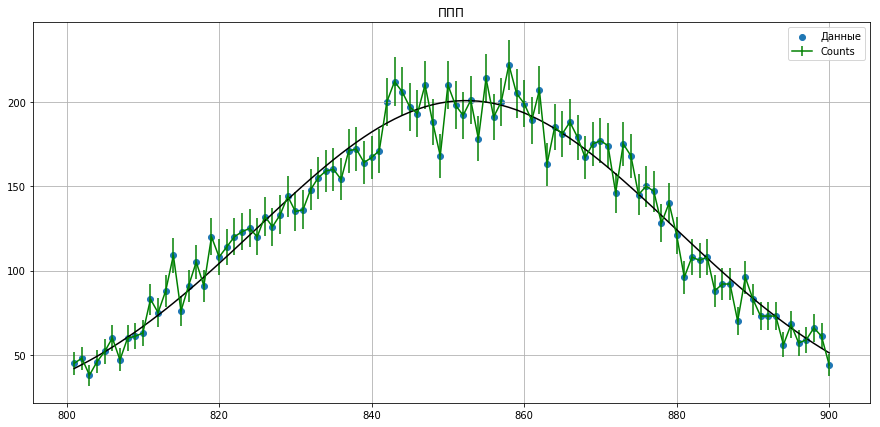

In [122]:
draw(data_cs_pp, 'ППП'.decode('utf-8'), True)
plt.plot(data_cs_pp['Channel'], gauss_function_c(data_cs_pp['Channel'], *popt_cs_pp), color = 'black')
plt.show()

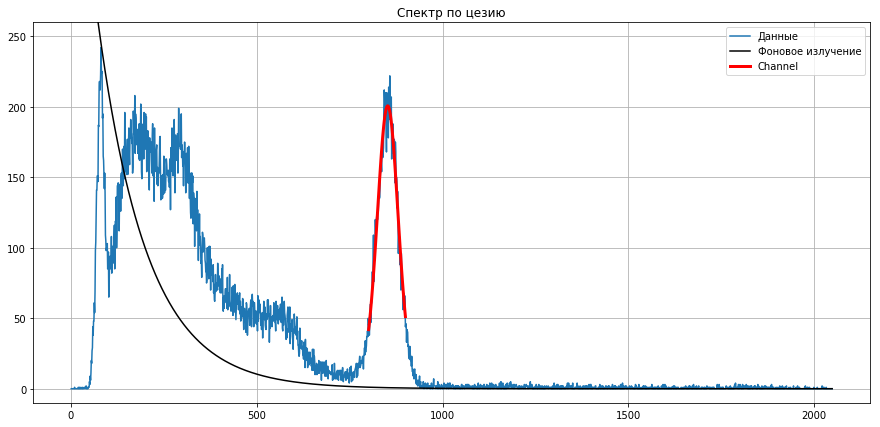

In [123]:
draw(data_cs, 'Спектр по цезию'.decode('utf-8'))
plt.plot(data_b['Channel'], exp(data_b['Channel'], *popt_b), color = 'black', label = 'Фоновое излучение'.decode('utf-8'))
plt.plot(data_cs_pp['Channel'], gauss_function_c(data_cs_pp['Channel'], *popt_cs_pp), color = 'red', linewidth = 3)
plt.legend()
plt.ylim(-10,260)
plt.show()

Каналу ППП цезия $(85\pm3)\cdot 10$ соответсвтует энергия $E_{\text{ППП}} = 0.661 \text{ МэВ}$.